<a href="https://colab.research.google.com/github/StarDylan/FlowMatching/blob/main/MNIST_Conditional_Flow_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchcfm
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
%load_ext autoreload
%autoreload 2
import os

import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel

savedir = "models/cond_mnist"
os.makedirs(savedir, exist_ok=True)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 128
n_epochs = 10

mnist_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=mnist_transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 511kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.92MB/s]


In [ ]:
testset = datasets.MNIST(
    "../data",
    train=False,
    download=True,
    transform=mnist_transform,
)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=True, drop_last=True
)



In [ ]:
#################################
#    Class Conditional CFM
#################################

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [ ]:
train_losses = []

In [ ]:
if os.path.exists(os.path.join(savedir, "mnist_cfm.pt")):
    model.load_state_dict(torch.load(os.path.join(savedir, "mnist_cfm.pt")))
else:
  for epoch in range(n_epochs):
      running_loss = 0
      for i, data in enumerate(train_loader):
          optimizer.zero_grad()
          x1 = data[0].to(device)
          y = data[1].to(device)
          x0 = torch.randn_like(x1)
          t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
          vt = model(t, xt, y)
          loss = torch.mean((vt - ut) ** 2)
          loss.backward()
          optimizer.step()
          print(f"\r epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="")
          running_loss += loss.item()
      avg_loss = running_loss / len(train_loader)
      train_losses.append(avg_loss)
  torch.save(model.state_dict(), os.path.join(savedir, "mnist_cfm.pt"))

 epoch: 3, steps: 155, loss: 0.1512

KeyboardInterrupt: 

In [ ]:
train_losses

[0.15918119407744488, 0.15845090399185816, 0.15711764551890203]

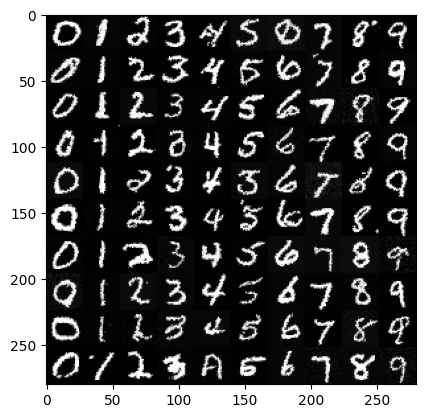

In [ ]:
generated_class_list = torch.arange(10, device=device).repeat(10)
with torch.no_grad():
      traj = torchdiffeq.odeint(
          lambda t, x: model.forward(t, x, generated_class_list),
          torch.randn(100, 1, 28, 28, device=device),
          torch.linspace(0, 1, 2, device=device),
          atol=1e-4,
          rtol=1e-4,
          method="dopri5",
      )

grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

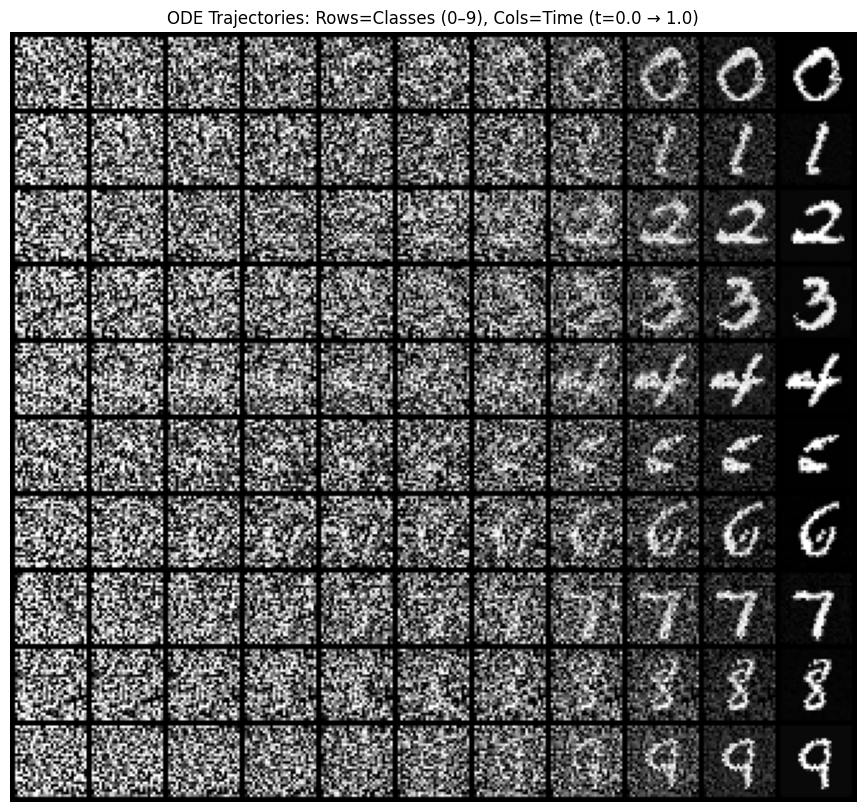

tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000], device='cuda:0')

In [ ]:
generated_class_list = torch.arange(10, device=device)

# One random image per class
x0 = torch.randn(10, 1, 28, 28, device=device)

# 10 time points from t=0.0 to t=0.9
timesteps = torch.linspace(0.0, 1.0, 11, device=device)

# Solve ODE
with torch.no_grad():
    traj = torchdiffeq.odeint(
        lambda t, x: model.forward(t, x, generated_class_list),
        x0,
        timesteps,
        atol=1e-4,
        rtol=1e-4,
        method="dopri5",
    )
    # traj shape: [10 time steps, 10 classes, 1, 28, 28]

# Rearrange so we can grid as [class0_t0, class0_t1, ..., class9_t9]
# Swap to shape [classes, timesteps, 1, 28, 28]
traj = traj.permute(1, 0, 2, 3, 4).contiguous()  # [10, 10, 1, 28, 28]
images = traj.view(-1, 1, 28, 28)  # [100, 1, 28, 28]

# Make a grid: 10 rows (classes), 10 columns (timesteps)
grid = make_grid(images.clip(-1, 1), value_range=(-1, 1), padding=2, nrow=11)
img = ToPILImage()(grid)

# Show the image
plt.figure(figsize=(11, 10))
plt.imshow(img)
plt.axis('off')
plt.title("ODE Trajectories: Rows=Classes (0–9), Cols=Time (t=0.0 → 1.0)")
plt.show()
timesteps

In [ ]:
traj.shape

torch.Size([10, 11, 1, 28, 28])

In [ ]:
x0 = torch.randn(10, 1, 28, 28, device=device)

# 10 time points from t=0.0 to t=0.9
timesteps = torch.linspace(0.0, 1.0, 11, device=device)

# Solve ODE
with torch.no_grad():
    traj = torchdiffeq.odeint(
        lambda t, x: model.forward(t, x, generated_class_list),
        x0,
        timesteps,
        atol=1e-4,
        rtol=1e-4,
        method="dopri5",
    )
    # traj shape: [10 time steps, 10 classes, 1, 28, 28]

to_pil = ToPILImage()
frames = []
for i in range(len(timesteps)):
    images = traj[i].clip(-1, 1)  # shape [10, 1, 28, 28]
    grid = make_grid(images, nrow=10, padding=2, value_range=(-1, 1))
    frame = to_pil(grid)
    frames.append(frame)

frames.extend([frames[-1]] * 5)

# Save as GIF
frames[0].save(
    "ode_evolution.gif",
    save_all=True,
    append_images=frames[1:],
    duration=300,  # duration per frame in ms
    loop=0
)

In [ ]:
#################################
#   NOT Class Conditional CFM
#################################

sigma = 0.0
model_ncfm = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, class_cond=False
).to(device)
optimizer_ncfm = torch.optim.Adam(model_ncfm.parameters())
node_ncfm = NeuralODE(model_ncfm, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [ ]:
if os.path.exists(os.path.join(savedir, "mnist_ncfm.pt")):
    model_ncfm.load_state_dict(torch.load(os.path.join(savedir, "mnist_ncfm.pt")))
else:
  for epoch in range(5):
      for i, data in enumerate(train_loader):
          optimizer_ncfm.zero_grad()
          x1 = data[0].to(device)
          y = data[1].to(device)
          x0 = torch.randn_like(x1)
          t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
          vt = model_ncfm(t, xt)
          loss = torch.mean((vt - ut) ** 2)
          loss.backward()
          optimizer_ncfm.step()
          print(f"\r epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="")
  torch.save(model_ncfm.state_dict(), os.path.join(savedir, "mnist_ncfm.pt"))

 epoch: 4, steps: 467, loss: 0.1647

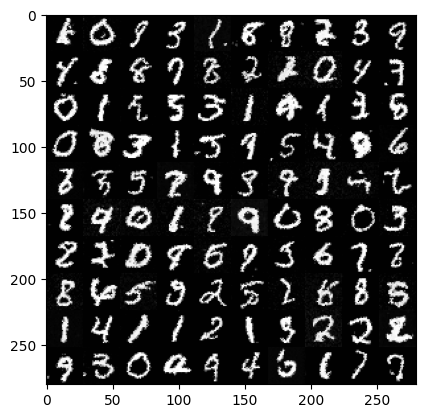

In [ ]:
with torch.no_grad():
      traj = torchdiffeq.odeint(
          lambda t, x: model_ncfm.forward(t, x),
          torch.randn(100, 1, 28, 28, device=device),
          torch.linspace(0, 1, 2, device=device),
          atol=1e-4,
          rtol=1e-4,
          method="dopri5",
      )

grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [ ]:
autoencoder_batch_size = 32

test_dataset = datasets.MNIST(
    "../data",
    train=False,
    download=True,
    transform=mnist_transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=autoencoder_batch_size, shuffle=True, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=autoencoder_batch_size, shuffle=False
)

Autoencoder from [wikibook/keras](https://github.com/wikibook/keras/blob/master/chapter3-autoencoders/autoencoder-2dim-mnist-3.2.2.py)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # -> (32, 14, 14)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (64, 7, 7)
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(64 * 7 * 7, latent_dim)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (32, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (1, 28, 28)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 64, 7, 7)
        x = self.deconv(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


In [ ]:
train_losses = []

In [ ]:
latent_dim = 2
autoencoder = Autoencoder(latent_dim).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

if os.path.exists(os.path.join(savedir, f"mnist_autoencoder_latent={latent_dim}.pt")) and False:
    autoencoder.load_state_dict(torch.load(os.path.join(savedir, f"mnist_autoencoder_latent={latent_dim}.pt")))

else:
  n_epochs = 20
  for epoch in range(n_epochs):
      autoencoder.train()
      running_loss = 0
      for i, batch in enumerate(train_loader):
          imgs, _ = batch
          imgs = imgs.to(device)

          optimizer.zero_grad()
          outputs = autoencoder(imgs)
          loss = criterion(outputs, imgs)
          loss.backward()
          optimizer.step()
          running_loss += loss.item()

          print(f"\r epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="")
      avg_loss = running_loss / len(train_loader)
      train_losses.append(avg_loss)
      print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {running_loss:.4f}")
  torch.save(autoencoder.state_dict(), os.path.join(savedir, f"mnist_autoencoder_latent={latent_dim}.pt"))

 epoch: 0, steps: 1874, loss: 0.2046Epoch [1/20], Loss: 404.9634
 epoch: 1, steps: 1874, loss: 0.1749Epoch [2/20], Loss: 362.3260
 epoch: 2, steps: 1874, loss: 0.219Epoch [3/20], Loss: 349.7797
 epoch: 3, steps: 1874, loss: 0.1777Epoch [4/20], Loss: 343.6389
 epoch: 4, steps: 1874, loss: 0.1616Epoch [5/20], Loss: 339.4134
 epoch: 5, steps: 1874, loss: 0.1764Epoch [6/20], Loss: 336.0447
 epoch: 6, steps: 1874, loss: 0.1737Epoch [7/20], Loss: 333.6235
 epoch: 7, steps: 1874, loss: 0.1468Epoch [8/20], Loss: 331.5773
 epoch: 8, steps: 1874, loss: 0.1857Epoch [9/20], Loss: 330.0271
 epoch: 9, steps: 1874, loss: 0.1918Epoch [10/20], Loss: 328.4588
 epoch: 10, steps: 1874, loss: 0.1745Epoch [11/20], Loss: 327.2547
 epoch: 11, steps: 1874, loss: 0.1629Epoch [12/20], Loss: 326.2126
 epoch: 12, steps: 1874, loss: 0.1563Epoch [13/20], Loss: 325.3368
 epoch: 13, steps: 1874, loss: 0.202Epoch [14/20], Loss: 324.4283
 epoch: 14, steps: 1874, loss: 0.1827Epoch [15/20], Loss: 323.4362
 epoch: 15, step

In [ ]:
train_losses

NameError: name 'train_losses' is not defined

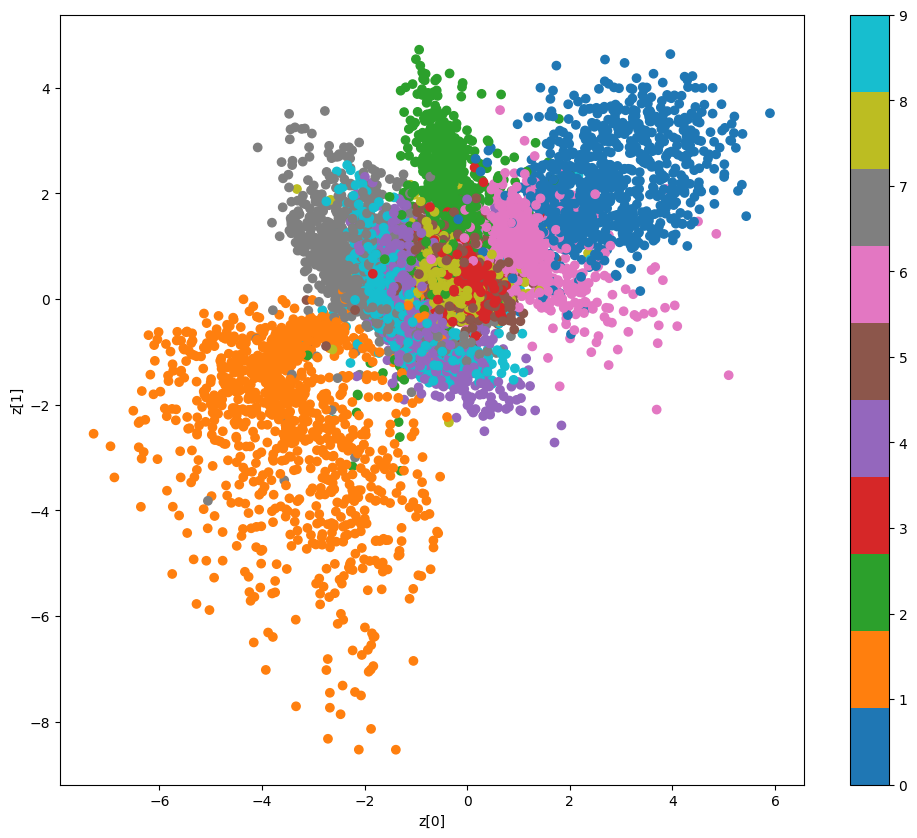

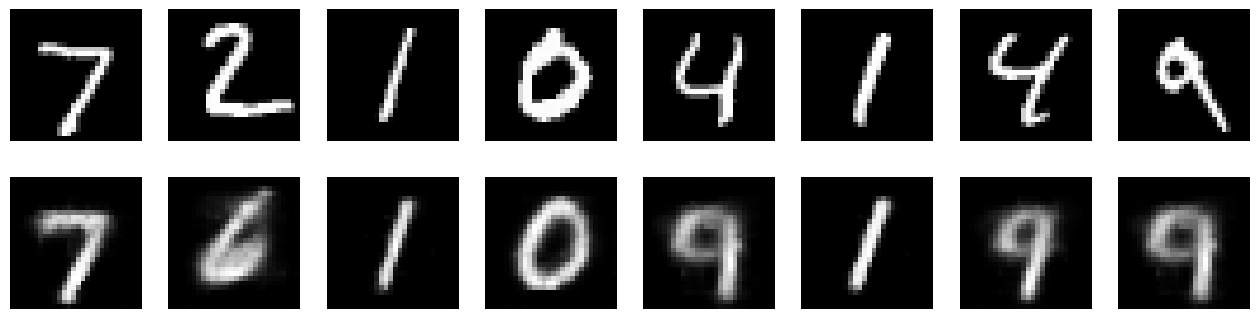

In [ ]:
import numpy as np

def plot_latent_space(encoder, data_loader, device, filename="latent_2dim.png"):
    encoder.eval()
    zs = []
    labels = []
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            z = encoder(x)
            zs.append(z.cpu())
            labels.append(y)
    zs = torch.cat(zs)
    labels = torch.cat(labels)

    plt.figure(figsize=(12, 10))
    plt.scatter(zs[:, 0], zs[:, 1], c=labels, cmap="tab10")
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()


def plot_reconstruction(model, data_loader, device, filename="reconstruction.png"):
    model.eval()
    with torch.no_grad():
        imgs, _ = next(iter(data_loader))
        imgs = imgs.to(device)[:8]
        outputs = model(imgs)

    imgs = imgs.cpu().numpy()
    outputs = outputs.cpu().numpy()
    comparison = np.concatenate([imgs, outputs])

    fig, axes = plt.subplots(2, 8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(comparison[i][0], cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(comparison[i + 8][0], cmap='gray')
        axes[1, i].axis('off')
    plt.savefig(filename)
    plt.show()


# Run visualizations
plot_latent_space(autoencoder.encoder, test_loader, device)
plot_reconstruction(autoencoder, test_loader, device)

(-6.0, 4.0)

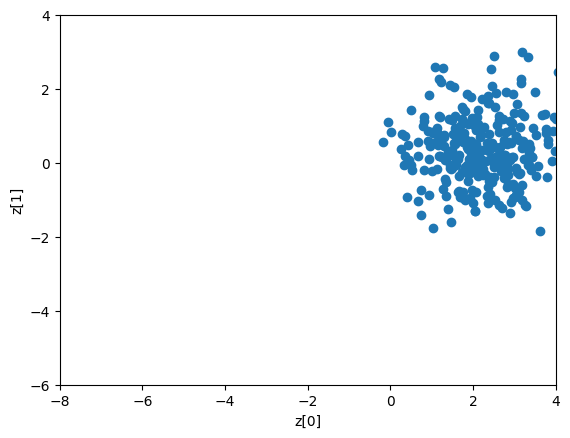

In [ ]:
import matplotlib.pyplot as plt
# Show random 100 points of noise with the MNIST shape
noise = torch.randn(300, 1, 28, 28, device=device)

# Run the noise through the autoencoder decoder
with torch.no_grad():
    latent_noise = autoencoder.encoder(noise)


cpu_latent = latent_noise.cpu().numpy()
plt.scatter(cpu_latent[:,0], cpu_latent[:, 1])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.xlim(-8, 4)
plt.ylim(-6, 4)


In [ ]:
import torch
import matplotlib.pyplot as plt
import imageio
import os

# Make sure these are defined
# noise: [batch_size, input_dim]
# model: CFM model
# autoencoder: trained autoencoder with 2D latent space
# device: 'cuda' or 'cpu'

# Prepare output directory
os.makedirs("latent_gif_frames", exist_ok=True)

# Create cyclic class labels
generated_class_list = torch.arange(len(noise), device=device) % 10

# Define timesteps
timesteps = torch.linspace(0.0, 1.0, 100, device=device)

# Run the ODE
with torch.no_grad():
    traj = torchdiffeq.odeint(
        lambda t, x: model.forward(t, x, generated_class_list),
        noise,
        timesteps,
        atol=1e-4,
        rtol=1e-4,
        method="dopri5",
    )

# Convert each time slice into latent space and plot
filenames = []
for i, t in enumerate(timesteps):
    with torch.no_grad():
        latent = autoencoder.encoder(traj[i]).cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.scatter(latent[:, 0], latent[:, 1], alpha=0.6, c=generated_class_list.cpu(), cmap='tab10')
    plt.title(f"Latent Space at t = {t:.2f}")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim(-8, 4)
    plt.ylim(-6, 4)
    plt.colorbar(label="Class")
    fname = f"latent_gif_frames/frame_{i:02d}.png"
    plt.savefig(fname)
    filenames.append(fname)
    plt.close()

# Create the GIF
gif_path = "latent_evolution.gif"
with imageio.get_writer(gif_path, mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Optionally clean up
# for filename in filenames:
#     os.remove(filename)

print(f"GIF saved to {gif_path}")


<ipython-input-19-33356829f4c9>:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved to latent_evolution.gif


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

from umap import UMAP
from umap.plot import points
import umap
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,\
                            confusion_matrix,\
                            classification_report,\
                            silhouette_score

# Visualization of PCA + UMAP
all_data = []
all_labels = []

for data, labels in train_loader:
    all_data.append(data.numpy())
    all_labels.append(labels.numpy())

# Concatenate all batches along the first axis
X_train = np.concatenate(all_data, axis=0)
y_train = np.concatenate(all_labels, axis=0)

flat_X_train = X_train.reshape(X_train.shape[0], -1)

final_pipeline = Pipeline([
    ("PCA", PCA(n_components=40)),
    ("UMAP", UMAP(n_components=2, random_state=42))
])
label = "PCA (d=40) ==> UMAP (d=2)"
final_pipeline = final_pipeline.fit(flat_X_train)

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.11/di

In [ ]:
import torch
import matplotlib.pyplot as plt
import imageio
import os

# Make sure these are defined
# noise: [batch_size, input_dim]
# model: CFM model
# autoencoder: trained autoencoder with 2D latent space
# device: 'cuda' or 'cpu'

# Prepare output directory
os.makedirs("latent_gif_frames", exist_ok=True)


# Convert each time slice into latent space and plot
filenames = []
for i, t in enumerate(timesteps):
    with torch.no_grad():
        latent = final_pipeline.transform(traj[i].cpu().numpy().reshape(traj[i].shape[0], -1))

    plt.figure(figsize=(8, 6))
    plt.scatter(latent[:, 0], latent[:, 1], alpha=0.6, c=generated_class_list.cpu(), cmap='tab10')
    plt.title(f"Latent Space at t = {t:.2f}")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.xlim(-3, 15)
    plt.ylim(-5, 15)
    plt.colorbar(label="Class")
    fname = f"latent_gif_frames/frame_{i:02d}.png"
    plt.savefig(fname)
    filenames.append(fname)
    plt.close()

# Create the GIF
gif_path = "latent_evolution_pca_umap.gif"
with imageio.get_writer(gif_path, mode='I', fps=10) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Optionally clean up
# for filename in filenames:
#     os.remove(filename)

print(f"GIF saved to {gif_path}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

GIF saved to latent_evolution_pca_umap.gif
